In [1]:
import mask
import numpy as np
from netCDF4 import Dataset
import cartopy.crs as ccrs
import cartopy
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from field_importer import get_field
import tqdm
import xarray as xr
from calendar import monthrange
import warnings
from scipy.spatial import Delaunay
import os
import cartopy
EASE_CRS = cartopy.crs.epsg('3408')
from scipy.stats import pearsonr
from importlib import reload
import pickle
import regrid
from cartoplot import cartoplot
from shapely.geometry import Point
from scipy.stats import binned_statistic
import ll_xy
from ll_xy import lonlat_to_xy
import shapely
from shapely.geometry import Point, LineString

%config Completer.use_jedi = False

/home/robbie/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/robbie/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


In [2]:
# Tell code where you're storing the data

tosh_drive = '/media/robbie/TOSHIBA EXT/AWI_regridded/'


lon_grid = np.array(mask.get('lon'))
lat_grid = np.array(mask.get('lat'))

# winter_month_names = {'10':'Oct','11':'Nov','12':'Dec','01':'Jan','02':'Feb','03':'Mar','04':'Apr'}

In [3]:
conc_dict_wkly = pickle.load(open('../processors/weekly_conc_dict.p', 'rb'))

# Define Gates

In [4]:
def get_data_near_line(p1,
                       p2,
                       dist_thresh_m,
                       xy_points_grid=None):
    
    """ Gets the distance of all points from the line"""
    
    if xy_points_grid == None:
        x_grid, y_grid = lonlat_to_xy(lon_grid,lat_grid,hemisphere='n')
        xy_grid = np.stack([x_grid,y_grid])
        points = [Point(x,y) for x, y in zip(x_grid.ravel(), y_grid.ravel())]
    else: points = xy_points_grid
        
    p1_xy = lonlat_to_xy([p1[0]],[p1[1]],hemisphere='n')
    p2_xy = lonlat_to_xy([p2[0]],[p2[1]],hemisphere='n')
    p1_xy = (p1_xy[0][0], p1_xy[1][0])
    p2_xy = (p2_xy[0][0], p2_xy[1][0])

    line = LineString([p1_xy, p2_xy])
    
    # Calculate point distances from line
    
    dists_from_line = [line.distance(point) for point in points]
    
    # Calculate distances along line by projection
        
    dists_along_line = [line.project(point) for point in points]
    
    # Reshape both arrays to grids

    dists_from_line_grid = np.array(dists_from_line).reshape(361,361)
    dists_along_line_grid = np.array(dists_along_line).reshape(361,361)
    
    # Make a gate mask based on the distance of points from the gate
    
    gate_mask = np.ones((361,361))
    gate_mask = np.ma.masked_where(dists_from_line_grid > dist_thresh_m, gate_mask)
    gate_mask = np.ma.filled(gate_mask, np.nan)
    
    # Make a grid of distances along line for points in range
    
    valid_distances_along = np.ma.masked_where(gate_mask!=1, dists_along_line_grid)
    valid_distances_along = np.ma.filled(valid_distances_along, np.nan)
    
    return(gate_mask, valid_distances_along ,line)

East Beaufort 917548.7119675593
Fram Strait 461466.960211752
West Beaufort 905240.0369231737
TPD 1121713.5018642002


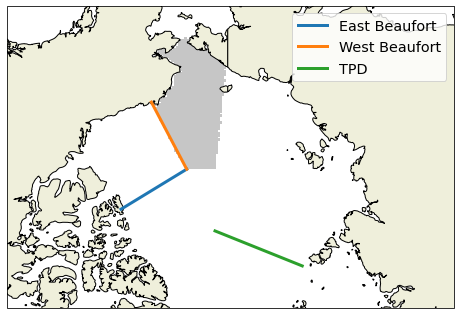

In [5]:
line_width = 50_000

x_grid, y_grid = lonlat_to_xy(lon_grid,lat_grid,hemisphere='n')
xy_grid = np.stack([x_grid,y_grid])
points = [Point(x,y) for x, y in zip(x_grid.ravel(), y_grid.ravel())]

join_point = (203,78.7)

tpd_coords = [(200,86), (90,82)]

gate_coords = [[(242,77), join_point], [(348,81),(11,79.5)], [(205,70.5),join_point], tpd_coords]
gate_names = ['East Beaufort','Fram Strait','West Beaufort', 'TPD']

gate_dict = {}

for coords, name in zip(gate_coords[:], gate_names[:]):
    
    gate_mask, valid_distances_along, line =  get_data_near_line(coords[0],
                                                                 coords[1],
                                                                 line_width,
                                                                 xy_points_grid=points)
    end_points = line.boundary
    
    print(name, line.length)
    
    angle_r = np.arctan2(end_points[1].x - end_points[0].x, end_points[1].y - end_points[0].y)
    angle_d = np.degrees(angle_r)
    

    gate_dict[name] = {'gate_mask':gate_mask,
                       'line':line,
                       'dist_along':valid_distances_along,
                       'end_points':end_points,
                       'angle_r':angle_r,
                       'angle_d':angle_d}
    
pickle.dump(gate_dict, open('gd.p','wb'))

#########################################################################

fig = plt.figure(figsize=(8,8))    

ax = plt.axes(projection=ccrs.NorthPolarStereo())

ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)

ax.set_extent([-180, 180, 90, 66], ccrs.PlateCarree())

handles = []

for gate in ['East Beaufort','West Beaufort', 'TPD']:
    
    point1, point2 = gate_dict[gate]['end_points']
    
#     print(point1)

    handles.append(ax.plot([point1.x, point2.x],[point1.y, point2.y],
#              color='k',
#              ls=':',
             lw=3,
             label=gate))


ax.legend(loc='upper right', fontsize='x-large')

chuk = mask.select_region('Chukchi',np.ones((361,361)))
ax.pcolormesh(lon_grid,lat_grid,chuk[:-1,:-1],transform=ccrs.PlateCarree(),cmap='Greys_r',vmin=0,vmax=1.5)
    
    

ax.set_extent([-2.633e+06,
               2.696e+06,
               -5e5,
               3.1e+06], crs=ccrs.NorthPolarStereo()) 


# Plot weekly fluxes with NSIDC vectors and CS2-SMOS thickness

In [6]:
def get_gate_comp(dX,dY,gate):

    if gate in ['West Beaufort', 'East Beaufort']:
        gate_comp = dY * np.sin(gate_dict[gate]['angle_r'])  - dX * np.cos(gate_dict[gate]['angle_r'])
    elif gate in ['Fram Strait','TPD']:
        gate_comp = dX * np.cos(gate_dict[gate]['angle_r']) - dY * np.sin(gate_dict[gate]['angle_r'])
    else: 
        print(gate)
        raise
        
    return gate_comp

def calculate_flux(gate_velocities, sit, MYI_dist, gate_data, plot=False, concs=np.nan):
    
    # Make blank arrays

    area_arr = np.full(gate_velocities.shape[0], np.nan)
    MYI_area_arr = np.full(gate_velocities.shape[0], np.nan)
    vol_arr = np.full(gate_velocities.shape[0], np.nan)
    
    MYI_velocities = np.multiply(gate_velocities, MYI_dist)
    
    for i in range(area_arr.shape[0]):
        
        list_of_tups = [(gate_velo,
                         MYI_velo,
                         gate_mask,
                         t)        for (gate_velo,
                                        MYI_velo,
                                         gate_mask,
                                         t)           in zip(gate_velocities[i].ravel(),
                                                             MYI_velocities[i].ravel(),
                                                              gate_data['dist_along'].ravel(),
                                                              sit[i].ravel(),
                                                              ) if (~np.isnan(gate_velo) & ~np.isnan(gate_mask))]
        
        val_vels, MYI_vels, val_dists, val_sits = zip(*list_of_tups)

        af, bin_edges, bn = binned_statistic(val_dists,val_vels,bins=20)
        
        MYI_af, bin_edges, bn = binned_statistic(val_dists,MYI_vels,bins=20)
        
        if plot:
            plt.scatter(val_dists,val_vels,marker='x')        
            plt.plot(bin_edges[1:],af,marker='o')
            print(af)
            plt.show()
            
        area_arr[i] = np.trapz(np.nan_to_num(af),bin_edges[1:])
        
        MYI_area_arr[i] = np.trapz(np.nan_to_num(MYI_af),bin_edges[1:])
        
        if np.count_nonzero(sit):
            vol_fluxes = np.multiply(val_sits, val_vels)
            vf, bin_edges, bn = binned_statistic(val_dists,vol_fluxes,bins=20)
            vol_arr[i] = np.trapz(np.nan_to_num(vf),bin_edges[1:])        

    return (area_arr,vol_arr, MYI_area_arr)

## Make a 12-week series of velocity vectors for each winter

In [7]:
def get_2020_21():
    
    d = Dataset('/media/robbie/TOSHIBA EXT/weekly_NSIDC_IMV/icemotion_weekly_nh_25km_20200101_20210304_ql.nc')
    
    u = d['u'][48:60]
    v = d['v'][48:60]
    
    return(u,v)

def get_first_eight(winter_year):
    data_dir = '/media/robbie/TOSHIBA EXT/weekly_NSIDC_IMV/'
    fname = f'icemotion_weekly_nh_25km_{winter_year}0101_{winter_year}1231_v4.1.nc'
    d = Dataset(f'{data_dir}{fname}')
    
    u = np.array(d['u'][:8])
    v = np.array(d['v'][:8])
    
    return(u,v)

def get_last_four(winter_year):
    data_dir = '/media/robbie/TOSHIBA EXT/weekly_NSIDC_IMV/'
    fname = f'icemotion_weekly_nh_25km_{winter_year-1}0101_{winter_year-1}1231_v4.1.nc'
    d = Dataset(f'{data_dir}{fname}')
    u = np.array(d['u'][-4:])
    v = np.array(d['v'][-4:])
    return(u,v)

vels = {}

for winter_year in tqdm.trange(1980,2022):

    
    if winter_year < 2021:
        u8,v8 = get_first_eight(winter_year)
        u4,v4 = get_last_four(winter_year)

        u = np.concatenate([u4,u8])
        v = np.concatenate([v4,v8])
        
    elif winter_year == 2021:
        u, v = get_2020_21()
    
    u = np.ma.masked_where(u == -9999, u)
    v = np.ma.masked_where(v == -9999, v)
    u = np.ma.filled(u,np.nan)/100
    v = np.ma.filled(v,np.nan)/100
#     cartoplot(elons,elats,u[0],land=False)
    
    vels[winter_year] = (u,v)

100%|██████████| 42/42 [00:08<00:00,  5.08it/s]


## Get a 12-week series of ice ages (and total MYI areas) for every year.

In [8]:
d = Dataset('/media/robbie/TOSHIBA EXT/weekly_NSIDC_age/iceage_nh_12.5km_20200101_20210304_ql.nc')
lon722 = d['longitude']
lat722 = d['latitude']

def age_to_mask(age):
    
    ones = np.ones((age.shape[0],722,722))
    
    ones[age<2] = 0
    ones[age>15] = 0
    
    ease_MYI = np.full((age.shape[0],361,361), 0)
    
    for i in range(age.shape[0]):
    
        ease_MYI[i] = regrid.regrid(ones[i], lon722,lat722,lon_grid,lat_grid,method='nearest')
    
    return(ease_MYI)

def get_2020_21():
    
    d = Dataset('/media/robbie/TOSHIBA EXT/weekly_NSIDC_age/iceage_nh_12.5km_20200101_20210304_ql.nc')
    
    age = d['age_of_sea_ice'][48:60]
    
    MYI = age_to_mask(age)

    return MYI

def get_first_eight(winter_year):
    data_dir = '/media/robbie/TOSHIBA EXT/weekly_NSIDC_age/'
    fname = f'iceage_nh_12.5km_{winter_year}0101_{winter_year}1231_v4.1.nc'
    d = Dataset(f'{data_dir}{fname}')
    
    age = np.array(d['age_of_sea_ice'][:8])
    
    MYI = age_to_mask(age)
   
    return MYI

def get_last_four(winter_year):
    data_dir = '/media/robbie/TOSHIBA EXT/weekly_NSIDC_age/'
    fname = f'iceage_nh_12.5km_{winter_year-1}0101_{winter_year-1}1231_v4.1.nc'
    d = Dataset(f'{data_dir}{fname}')
    age = np.array(d['age_of_sea_ice'][-4:])
    
    MYI = age_to_mask(age)
    
    return MYI

MYIs = {}

for winter_year in tqdm.trange(1985,2022):

    
    if winter_year < 2021:
        MYI8 = get_first_eight(winter_year)
        MYI4 = get_last_four(winter_year)

        MYI = np.concatenate([MYI4,MYI8])
        
    elif winter_year == 2021:
        MYI = get_2020_21()
    
    MYIs[winter_year] = MYI
    
    

for winter_year in range(1980,1985):
    MYIs[winter_year] = np.zeros((12,361,361))

100%|██████████| 37/37 [03:11<00:00,  5.17s/it]


In [14]:
pickle.dump(MYIs, open('myi_12.p','wb'))
MYIs = pickle.load(open('../pickles/myi_12.p','rb'))

## Calculate the area fluxes

In [25]:
a_fluxes_wkly = {}
myi_frac_flux_wkly = {}

# for gate in gate_names:
    
for gate in ['East Beaufort', 'West Beaufort']:

    gate_data = gate_dict[gate]
    
    a_fluxes_wkly[gate] = {}
    myi_frac_flux_wkly[gate] = {}
    
    sit = np.zeros((12,361,361))

#     for winter_year in tqdm.trange(1980,2022):
    for winter_year in tqdm.trange(1980,2022):
        
        concs = conc_dict_wkly[winter_year]
        
        MYI_dist = MYIs[winter_year]
        
        u, v = vels[winter_year] #These velocities are in m/s
            
        missing_bit = np.ma.masked_where(~np.isnan(u), concs); missing_bit = np.ma.filled(missing_bit, np.nan)
        
#         cartoplot(lon_grid, lat_grid, missing_bit)
        
        # WEIGHT THE VELOCITIES WITH THE CONCENTRATIONS
        
        u = np.multiply(u,concs)
        v = np.multiply(v,concs)
        
        # Rotate the vectors to get component normal to the gate
        
        gate_comp = get_gate_comp(u,v,gate) #m/s
        
        # Mask the rotated vectors and the concs for the gate

        gate_velocities = np.multiply(gate_comp, gate_data['gate_mask'])
        gate_concs = np.multiply(concs, gate_data['gate_mask'])
        
        myi_areas = np.nansum(MYI_dist,axis=(1,2))*628.35e6 # MYI area in m2

        a,v,myi_a = calculate_flux(gate_velocities,
                             sit,
                             MYI_dist,
                             gate_data,
                             plot=False,
                             concs=gate_concs)
        
        myi_frac = np.divide(myi_a*(7*24*3600),myi_areas)
        
        # Calculate weekly flux timeseries in km2
        
        a_fluxes_wkly[gate][winter_year] = a*(7*24*3600)/1e6 # (seconds_in_week)/(square meters in 1 km2)
        
        myi_frac_flux_wkly[gate][winter_year] = myi_frac

100%|██████████| 42/42 [04:58<00:00,  7.10s/it]



# Write results out to figures directory

In [10]:
# pickle.dump(a_fluxes_wkly, open('../figure2_current/wklyfluxes.p','wb'))

a_fluxes_wkly = pickle.load(open('../figure2_current/wklyfluxes.p','rb'))

pickle.dump(myi_frac_flux_wkly, open('../pickles/myi_frac_flux_both_gates.p','wb'))

myi_frac_flux_wkly = pickle.load(open('../pickles/myi_frac_flux_both_gates.p','rb'))

100%|██████████| 42/42 [00:00<00:00, 580.44it/s]


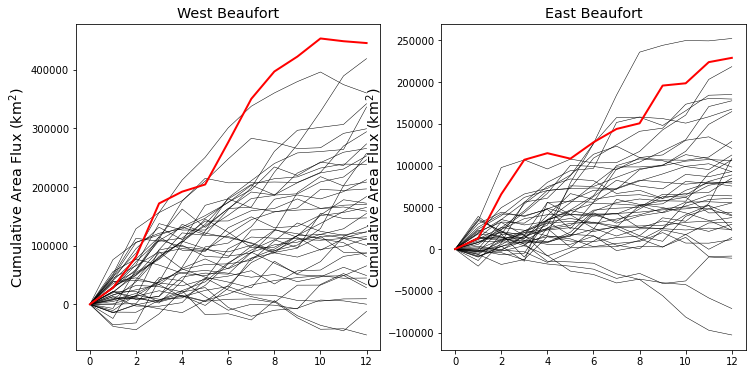

In [11]:
years = tqdm.trange(1980,2022)

# for gate in gate_names:
    
fig, axs = plt.subplots(1,2,figsize=(12,6))
    

for gate, ax in zip(['West Beaufort', 'East Beaufort'],axs.reshape(-1)):

    for year in years:
        if year != 2021:
            color='k'
            lw=0.5
        elif year == 2021:
            color = 'r'
            lw=2

#         if year == 2018: color = 'b'

        ax.plot(np.arange(13),[0]+list(np.cumsum(a_fluxes_wkly[gate][year])), color=color, lw=lw)

    ax.set_ylabel(r'Cumulative Area Flux (km$^2$)', fontsize='x-large')
    ax.set_title(gate,fontsize='x-large')
    
plt.show()

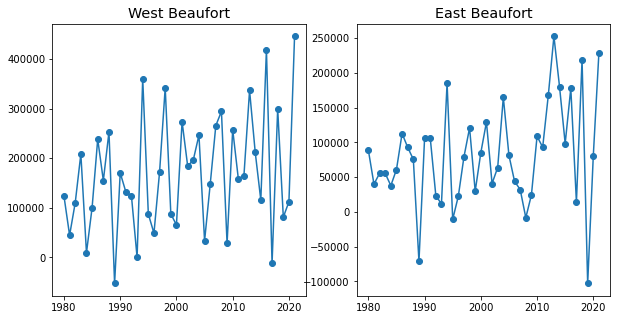

In [12]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
    

flux_series = {}
for gate, ax in zip(['West Beaufort', 'East Beaufort'],axs.reshape(-1)):

    flux_series[gate] = []
    for year in years:
        flux = np.sum(a_fluxes_wkly[gate][year])
        flux_series[gate].append(flux)

    ax.plot(list(years),flux_series[gate],marker='o')
    ax.set_title(gate,fontsize='x-large')

plt.show()

In [13]:
myi_frac_flux_wkly['East Beaufort'].keys()

dict_keys([1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021])

100%|██████████| 33/33 [00:00<00:00, 1142.81it/s]


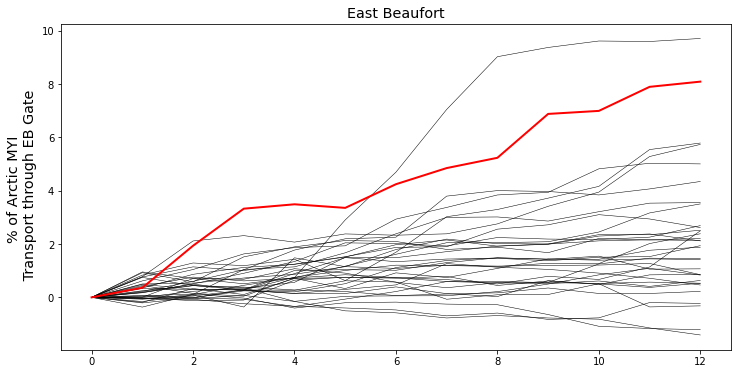

In [14]:
years = tqdm.trange(1989,2022)

# for gate in gate_names:
    
fig, ax = plt.subplots(1,1,figsize=(12,6))
    

gate = 'East Beaufort'

for year in years:
    
    if year != 2021:
        color='k'
        lw=0.5
    elif year == 2021:
        color = 'r'
        lw=2

#         if year == 2018: color = 'b'

    ax.plot(np.arange(13),[0]+list(np.cumsum(myi_frac_flux_wkly[gate][year])*100), color=color, lw=lw)

ax.set_ylabel(f'% of Arctic MYI \n Transport through EB Gate', fontsize='x-large')
ax.set_title(gate,fontsize='x-large')
    
plt.show()

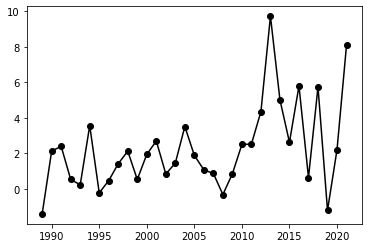

In [20]:
fig, ax = plt.subplots(1,1)

fracs = []
for year in range(1989,2022):
    fracs.append(np.sum(myi_frac_flux_wkly[gate][year])*100)

ax.plot(range(1989,2022),fracs,color='k',marker='o')

pickle.dump(fracs, open('../pickles/myi_frac_flux.p','wb'))

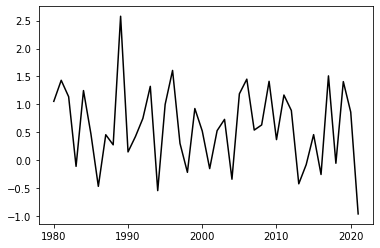

In [16]:
hourly_means = pickle.load(open('../figure1_current/vorts.p','rb'))

years = range(1980,2022)

ann_means = []

for counter, year in enumerate(years):
    
    if year == 2021:
        color = 'r'
        lw=1.5
    else:
        color = 'k'
        lw=0.3
    
    ann_means.append(np.nanmean(hourly_means[counter]))
    
plt.plot(years,ann_means,color='k')

In [17]:
corr_d = (flux_series,ann_means)
pickle.dump(corr_d, open('../figure2_current/corr_d.p','wb'))

Text(0.05, 0.12, 'WB Corr = -0.86')

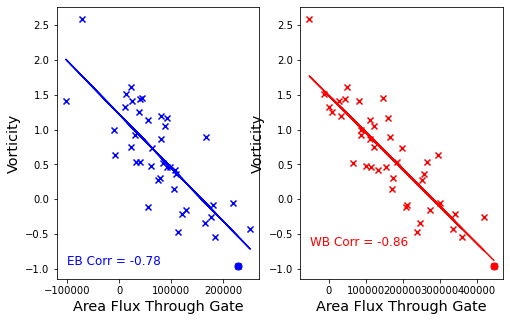

In [18]:
fig, (axl, axr) = plt.subplots(1,2,figsize=(8,5))

axl.scatter(flux_series['East Beaufort'], ann_means,color='b', marker='x', label='1979-2020 EB')
axr.scatter(flux_series['West Beaufort'], ann_means,color='r', marker='x', label='1979-2020 WB')

axl.scatter(flux_series['East Beaufort'][-1], ann_means[-1],color='b', marker='o',s=50, label='2021 EB')
axr.scatter(flux_series['West Beaufort'][-1], ann_means[-1],color='r', marker='o',s=50, label='2021 WB')

z = np.polyfit(flux_series['East Beaufort'], ann_means, 1)
p = np.poly1d(z)
axl.plot(flux_series['East Beaufort'], p(flux_series['East Beaufort']),color='b')

z = np.polyfit(flux_series['West Beaufort'], ann_means, 1)
p = np.poly1d(z)
axr.plot(flux_series['West Beaufort'], p(flux_series['West Beaufort']),color='r',marker='None')

for ax in [axl,axr]:
    ax.set_xlabel('Area Flux Through Gate', fontsize='x-large')
    ax.set_ylabel('Vorticity', fontsize='x-large')

ebcorr = np.round(pearsonr(flux_series['East Beaufort'], ann_means)[0], decimals=2)
wbcorr = np.round(pearsonr(flux_series['West Beaufort'], ann_means)[0], decimals=2)

axl.annotate(text=f'EB Corr = {ebcorr}',xy=(0.05,0.05),xycoords='axes fraction', fontsize='large', color='b')
axr.annotate(text=f'WB Corr = {wbcorr}',xy=(0.05,0.12),xycoords='axes fraction', fontsize='large', color='r')

# Does a poleward displacement of the BSH drive higher vorticity and flux?

In [112]:
vort_list = []

for y,v in zip(years,ann_means):
    
    vort_list.append({'Year':y,
                      'vort':v})
    
vort_df = pd.DataFrame(vort_list)

vort_df.set_index('Year',inplace=True)

bsh_df = pickle.load(open('../pickles/SLP_max_coords.p','rb'))

bsh_df.set_index('Year',inplace=True)

pd.concat([bsh_df,vort_df])

m = bsh_df.merge(vort_df, left_index=True, right_index=True)

m['x'], m['y'] = lonlat_to_xy(np.array(m['Longitude']),
                              np.array(m['Latitude']),
                              hemisphere='n')

m['euro_disp'] = m['x'] - m['y']

m

,Max SLP (hPa),Longitude,Latitude,vort,x,y,euro_disp
Year,,,,,,,
1980,1022.3,168.25,77.50,1.054184,2.824982e+05,1.358163e+06,-1.075664e+06
1982,1023.6,-138.00,79.00,1.137031,-8.172161e+05,9.076104e+05,-1.724827e+06
1983,1024.1,-152.50,77.25,-0.110696,-6.533108e+05,1.254998e+06,-1.908309e+06
1986,1029.0,171.25,82.00,-0.468734,1.352177e+05,8.785237e+05,-7.433060e+05
1988,1021.4,-173.75,81.00,0.275098,-1.088409e+05,9.938193e+05,-1.102660e+06
1992,1018.6,-157.00,75.75,0.748465,-6.175519e+05,1.454861e+06,-2.072413e+06
1994,1031.5,-173.00,80.50,-0.545351,-1.285941e+05,1.047315e+06,-1.175909e+06
1997,1023.0,-161.00,76.50,0.300728,-4.876083e+05,1.416117e+06,-1.903726e+06
1998,1027.6,-180.00,78.00,-0.217929,-1.631168e-10,1.331949e+06,-1.331949e+06


In [67]:
from scipy.stats import linregress

LinregressResult(slope=-0.1811933052788511, intercept=14.408915248579248, rvalue=-0.621662534728648, pvalue=0.005882887902200925, stderr=0.05707519155930104, intercept_stderr=4.507198843062118)
LinregressResult(slope=-7.18090423348926e-07, intercept=-0.881705757362262, rvalue=-0.6167333977654018, pvalue=0.006407753909436456, stderr=2.291349670173988e-07, intercept_stderr=0.33478848100381164)


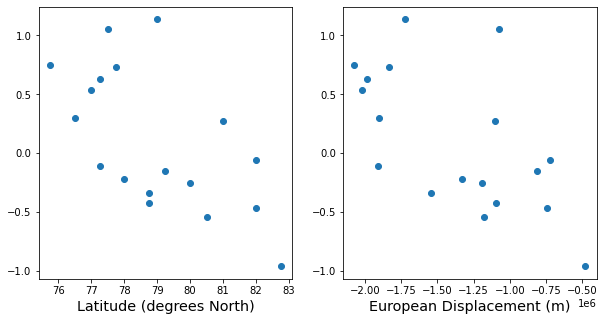

In [71]:
print(linregress(m['Latitude'], m['vort']))

print(linregress(m['euro_disp'], m['vort']))

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

ax1.scatter(m['Latitude'], m['vort'])

ax1.set_xlabel('Latitude (degrees North)', fontsize='x-large')


ax2.scatter(np.array(m['euro_disp']), m['vort'])

ax2.set_xlabel('European Displacement (m)', fontsize='x-large')

ax1.set_ylabel('Sea Ice Vorticity')

plt.show()

LinregressResult(slope=-0.11307700176416133, intercept=115.97848336741598, rvalue=-0.7715510768743284, pvalue=0.00017687477831464682, stderr=0.023308858655656635, intercept_stderr=23.8855423394673)


Text(0.01, 0.07, 'p = 0.0')

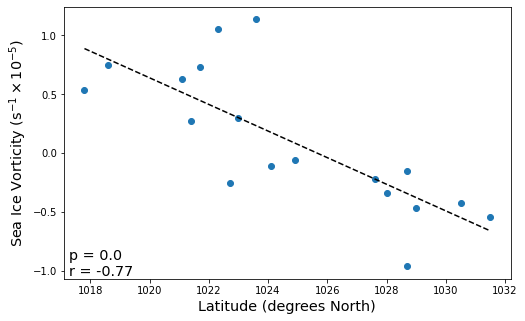

In [87]:
fig, ax1 = plt.subplots(1,1,figsize=(8,5))

ax1.scatter(m['Max SLP (hPa)'], m['vort'])

ax1.set_xlabel('Latitude (degrees North)', fontsize='x-large')

unit = r'(s$^{-1} \times 10^{-5}$)'
ax1.set_ylabel(f'Sea Ice Vorticity {unit}', fontsize='x-large')

stats = linregress(m['Max SLP (hPa)'], m['vort'])

print(stats)

ax1.plot([min(m['Max SLP (hPa)']),max(m['Max SLP (hPa)'])],
         [min(m['Max SLP (hPa)'])*stats[0]+stats[1],
          max(m['Max SLP (hPa)'])*stats[0]+stats[1]],
         color='k',
         ls='--')

ax1.annotate(xy=(0.01,0.01),
             xycoords='axes fraction',
             text=f'r = {np.round(stats[2],decimals=2)}',
             fontsize='x-large')

ax1.annotate(xy=(0.01,0.07),
             xycoords='axes fraction',
             text=f'p = {np.round(stats[3],decimals=3)}',
             fontsize='x-large')

LinregressResult(slope=-0.1811933052788511, intercept=14.408915248579248, rvalue=-0.621662534728648, pvalue=0.005882887902200925, stderr=0.05707519155930104, intercept_stderr=4.507198843062118)


Text(0.01, 0.07, 'p = 0.006')

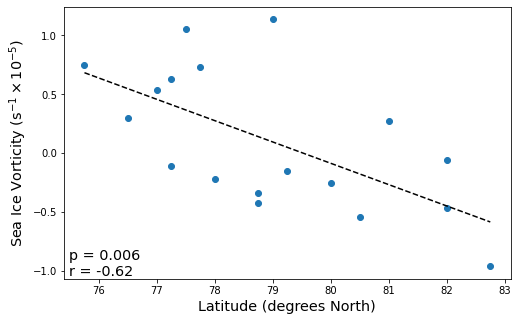

In [85]:
fig, ax1 = plt.subplots(1,1,figsize=(8,5))

ax1.scatter(m['Latitude'], m['vort'])

ax1.set_xlabel('Latitude (degrees North)', fontsize='x-large')

unit = r'(s$^{-1} \times 10^{-5}$)'
ax1.set_ylabel(f'Sea Ice Vorticity {unit}', fontsize='x-large')

stats = linregress(m['Latitude'], m['vort'])

print(stats)

ax1.plot([min(m['Latitude']),max(m['Latitude'])],
         [min(m['Latitude'])*stats[0]+stats[1],
          max(m['Latitude'])*stats[0]+stats[1]],
         color='k',
         ls='--')

ax1.annotate(xy=(0.01,0.01),
             xycoords='axes fraction',
             text=f'r = {np.round(stats[2],decimals=2)}',
             fontsize='x-large')

ax1.annotate(xy=(0.01,0.07),
             xycoords='axes fraction',
             text=f'p = {np.round(stats[3],decimals=3)}',
             fontsize='x-large')

LinregressResult(slope=-0.1811933052788511, intercept=14.408915248579248, rvalue=-0.621662534728648, pvalue=0.005882887902200925, stderr=0.05707519155930104, intercept_stderr=4.507198843062118)
LinregressResult(slope=-0.11307700176416133, intercept=115.97848336741598, rvalue=-0.7715510768743284, pvalue=0.00017687477831464682, stderr=0.023308858655656635, intercept_stderr=23.8855423394673)


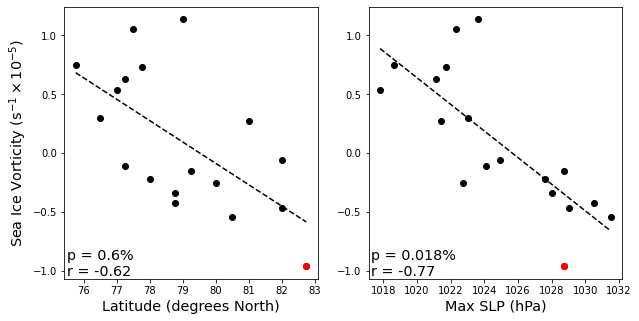

In [111]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

ax1.scatter(m['Latitude'], m['vort'],color='k')

ax1.scatter(list(m['Latitude'])[-1], 
            list(m['vort'])[-1],
            color='r',
            label='2020/21')

ax1.set_xlabel('Latitude (degrees North)', fontsize='x-large')

unit = r'(s$^{-1} \times 10^{-5}$)'
ax1.set_ylabel(f'Sea Ice Vorticity {unit}', fontsize='x-large')

stats = linregress(m['Latitude'], m['vort'])

print(stats)

ax1.plot([min(m['Latitude']),max(m['Latitude'])],
         [min(m['Latitude'])*stats[0]+stats[1],
          max(m['Latitude'])*stats[0]+stats[1]],
         color='k',
         ls='--')

ax1.annotate(xy=(0.01,0.01),
             xycoords='axes fraction',
             text=f'r = {np.round(stats[2],decimals=2)}',
             fontsize='x-large')

ax1.annotate(xy=(0.01,0.07),
             xycoords='axes fraction',
             text=f'p = {np.round(stats[3]*100,decimals=1)}%',
             fontsize='x-large')


##################################


ax2.scatter(m['Max SLP (hPa)'], m['vort'],color='k')

ax2.scatter(list(m['Max SLP (hPa)'])[-1], 
            list(m['vort'])[-1],
            color='r',
            label='2020/21')

ax2.set_xlabel('Max SLP (hPa)', fontsize='x-large')

# ax2.set_ylabel(f'Sea Ice Vorticity {unit}', fontsize='x-large')

stats = linregress(m['Max SLP (hPa)'], m['vort'])

print(stats)

ax2.plot([min(m['Max SLP (hPa)']),max(m['Max SLP (hPa)'])],
         [min(m['Max SLP (hPa)'])*stats[0]+stats[1],
          max(m['Max SLP (hPa)'])*stats[0]+stats[1]],
         color='k',
         ls='--')

ax2.annotate(xy=(0.01,0.01),
             xycoords='axes fraction',
             text=f'r = {np.round(stats[2],decimals=2)}',
             fontsize='x-large')

ax2.annotate(xy=(0.01,0.07),
             xycoords='axes fraction',
             text=f'p = {np.round(stats[3]*100,decimals=3)}%',
             fontsize='x-large')


sup_fig_dir = '/home/robbie/Dropbox/Apps/Overleaf/Beaufort/Sup_figs'
plt.savefig(f'{sup_fig_dir}/BSH_position_vorticity.jpg',dpi=500,bbox_inches='tight')

In [10]:
def get_daily_flux_data(year,month):
    preamble = '/media/robbie/TOSHIBA EXT/awi_cs2_smos/processed'
    d = Dataset(f'{preamble}/{year}{str(month).zfill(2)}.nc')
    return d  

def check_data(dX,dY):
    
    for f in [dX,dY]:
        if ~np.isnan(f[:,0,0]).any():
            print(gate,year,month)
            raise

d = get_daily_flux_data(2021,1)

elons = np.array(d['lon'])
elats = np.array(d['lat'])
sit = np.array(d['sit'])
dY = np.nanmean(d['dYr'],axis=0)
dX = np.nanmean(d['dXr'],axis=0)

In [11]:
gate_name = 'Fram Strait'

gate_data = gate_dict[gate_name]

dX = np.ma.filled(d['dXr'], np.nan)/48
dY = np.ma.filled(d['dYr'], np.nan)/48
sit = np.ma.filled(d['sit'], np.nan)

### DIVIDE BY 3600 TO GET KM PER SECOND ###

dX = dX/3600 ; dY = dY/3600

### MULTIPLY BY 1000 TO GET METERS PER SECOND ###

dX = dX*1000 ; dY = dY*1000

check_data(dX,dY)

# rotate to get IMV component perpendicular to gate

# EACH GRID CELL WILL BE IN M/S

gate_comp = get_gate_comp(dX,dY,gate_name)

gate_orientated_velocities = np.multiply(gate_comp, gate_data['gate_mask'])

# cartoplot(lon_grid,lat_grid, gate_data['gate_mask'],bounding_lat=75)
# cartoplot(lon_grid,lat_grid, gate_comp[5],bounding_lat=75)

a,v = calculate_flux(gate_orientated_velocities, sit, gate_data, plot=False)

NameError: name 'calculate_flux' is not defined

In [188]:
# years = np.arange(2012,2013)
years = np.arange(2011,2022)

v_fluxes = {}
a_fluxes = {}
tpd_bearings = {12:[],
                1:[],
                2:[]}

for gate in gate_names[:]:
# for gate in ['Fram Strait']:
    
    print(gate)
    
    v_fluxes[gate] = {12:{},
                       1:{},
                       2:{}}
    a_fluxes[gate] = {12:{},
                       1:{},
                       2:{}}

    
    for month in tqdm.tqdm([12,1,2]):

        for year in years:    

            if month > 5:
                year = year-1
                
            d = get_daily_flux_data(year,month)
            
            ### ORIGINAL DATA IS IN KM PER 48 HOURS ###
            
            ### THEREFORE DIVIDE BY 48 TO GET KM PER HR ###
            
            dX = np.ma.filled(d['dXr'], np.nan)/48
            dY = np.ma.filled(d['dYr'], np.nan)/48
            
            ### DIVIDE BY 3600 TO GET KM PER SECOND ###
            
            dX = dX/3600 ; dY = dY/3600
            
            ### MULTIPLY BY 1000 TO GET METERS PER SECOND ###
            
            dX = dX*1000 ; dY = dY*1000
            
            check_data(dX,dY)
            
            # rotate to get IMV component perpendicular to gate
            
            # EACH GRID CELL WILL BE IN M/S
            
            gate_comp = get_gate_comp(dX,dY,gate)
            
#             print(np.nanmean(gate_comp,axis=(1,2)))
                
            gate_mask = gate_dict[gate]['gate_mask']
            gate_velocities = np.multiply(gate_comp, gate_mask)

            area_flux, volume_flux = calculate_flux(gate_velocities, 
                                                     np.ma.filled(d['sit'], np.nan),
                                                     gate_dict[gate])
            
            a_fluxes[gate][month][year] = area_flux * 24 * 3600 / 1e6 # Save in km2/day
            v_fluxes[gate][month][year] = volume_flux * 24 * 3600 / 1e9 # Save in km3/day

            

        

  0%|          | 0/3 [00:00<?, ?it/s]

Fram Strait


100%|██████████| 3/3 [09:53<00:00, 197.71s/it]


In [11]:
# pickle.dump((a_fluxes,v_fluxes), open('fluxes.p','wb'))
(a_fluxes,v_fluxes) = pickle.load(open('fluxes.p','rb'))

In [12]:
def plot_a_fluxes(area_flux1,area_flux2):

    fig, ax = plt.subplots(1,1,figsize=(8,5))
    ax.plot(area_flux1,color='r')
    ax.set_ylabel('Integrated Flux',color='r')
    ax2 = ax.twinx()
    ax2.plot(area_flux2)
    ax2.set_ylabel('Estimated Flux')
    plt.show()

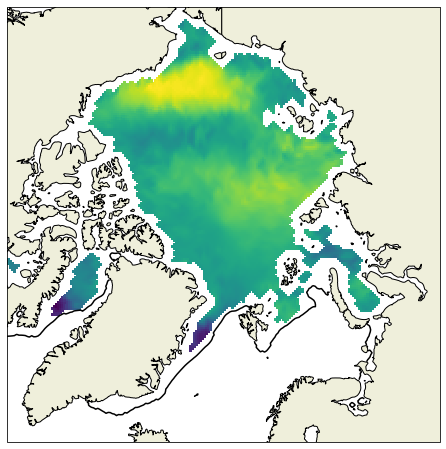

In [13]:
d = get_daily_flux_data(2011,2)


fig = plt.figure(figsize=(8,8))    

ax = plt.axes(projection=ccrs.NorthPolarStereo())

ax.set_extent([-180, 180, 90, 66], ccrs.PlateCarree())

ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)

ax.pcolormesh(lon_grid, lat_grid, d['dXr'][0][:-1,:-1], transform=ccrs.PlateCarree())
ax.contour(ease_x, ease_y, conc_dict_wkly[2011][5], levels=[0.5], transform=EASE_CRS, colors=['k'])

# Fram strait volume flux

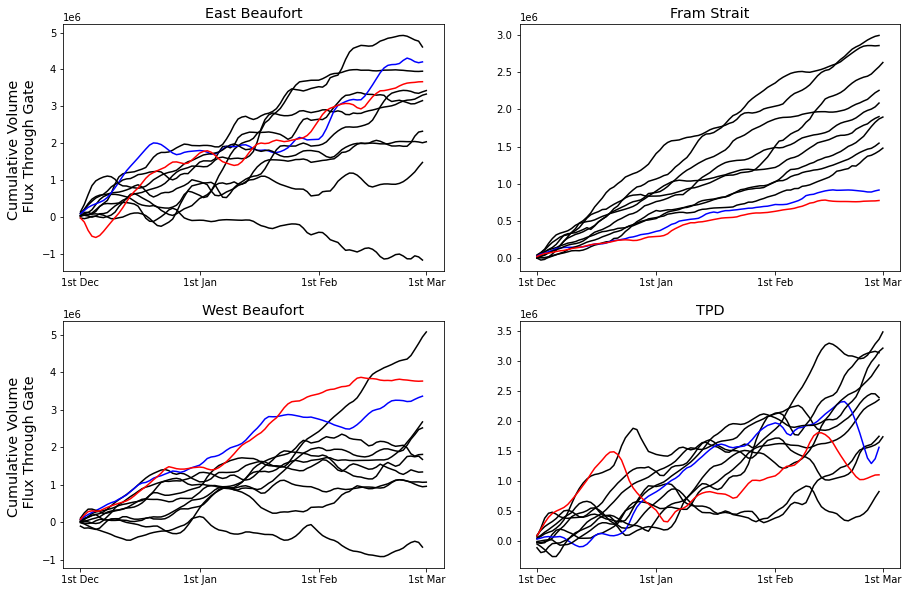

In [14]:
fig, axs = plt.subplots(2,2,figsize=(15,10))

for gate, ax in zip(gate_names,axs.reshape(-1)):
    
    for year in range(2011,2022):

        dec = v_fluxes[gate][12][year-1]
        jan = v_fluxes[gate][1][year]
        feb = v_fluxes[gate][2][year]
        
        season = list(dec) + list(jan) + list(feb)
        
        if year == 2018:
            color = 'b'
        elif year < 2021:
            color='k'
        else:
            color='r'

        ax.plot(range(len(season)),np.nancumsum(season),color)
        

        
    ax.set_title(gate,fontsize='x-large')
    
    if gate in ['East Beaufort','West Beaufort']:
        
        ax.set_ylabel('Cumulative Volume \n Flux Through Gate', fontsize='x-large')
    
    ax.set_xticks([0,31,31+31,31+31+28])
    ax.set_xticklabels(['1st Dec', '1st Jan', '1st Feb', '1st Mar'])

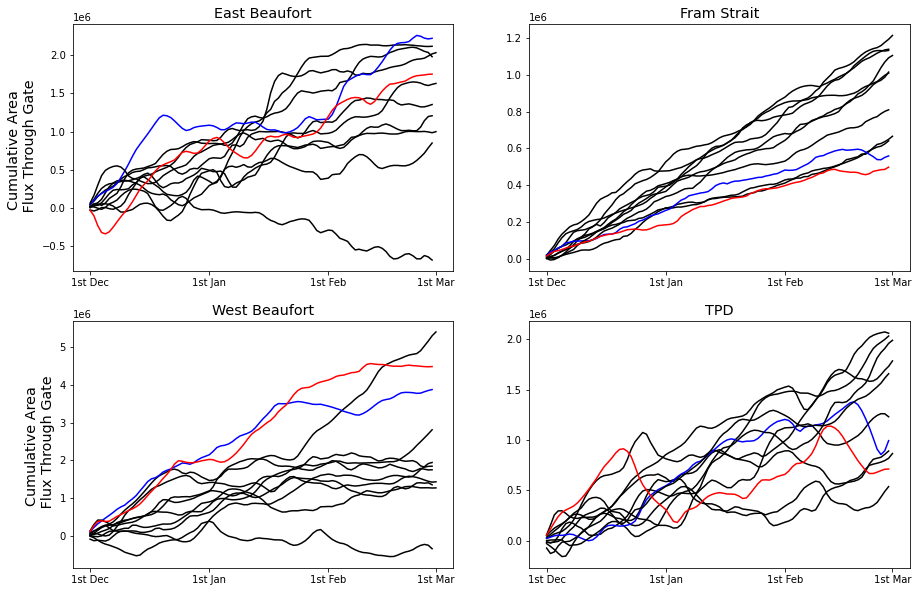

In [14]:
fig, axs = plt.subplots(2,2,figsize=(15,10))

for gate, ax in zip(gate_names,axs.reshape(-1)):
    
    for year in range(2011,2022):

        dec = a_fluxes[gate][12][year-1]
        jan = a_fluxes[gate][1][year]
        feb = a_fluxes[gate][2][year]
        
        season = list(dec) + list(jan) + list(feb)
        
        if year == 2018:
            color = 'b'
        elif year < 2021:
            color='k'
        else:
            color='r'

        ax.plot(range(len(season)),np.nancumsum(season),color)
        

        
    ax.set_title(gate,fontsize='x-large')
    
    if gate in ['East Beaufort','West Beaufort']:
        
        ax.set_ylabel('Cumulative Area \n Flux Through Gate', fontsize='x-large')
    
    ax.set_xticks([0,31,31+31,31+31+28])
    ax.set_xticklabels(['1st Dec', '1st Jan', '1st Feb', '1st Mar'])

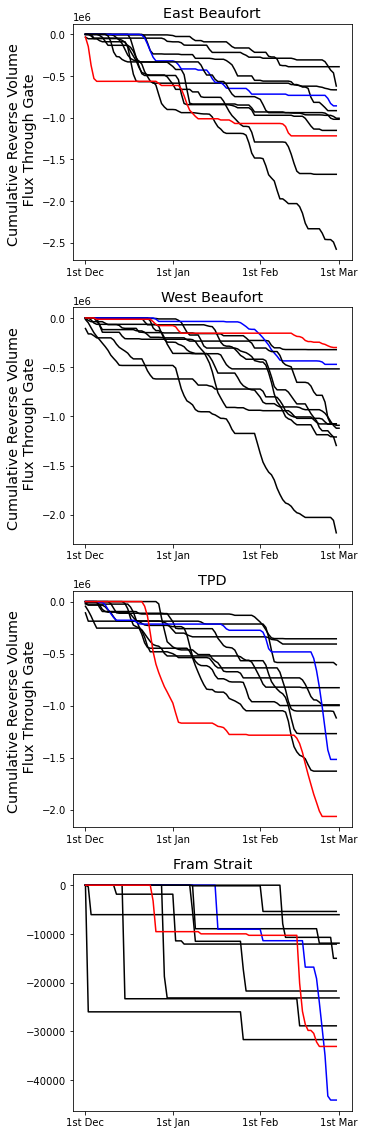

In [36]:
fig, axs = plt.subplots(4,1,figsize=(5,20))

rev_flow = {}

# for gate, ax in zip(gate_names,axs.reshape(-1)):
for gate, ax in zip(['East Beaufort','West Beaufort', 'TPD', 'Fram Strait'],axs.reshape(-1)):

    rev_flow[gate] = {}
    
    for year in range(2011,2022):

        dec = v_fluxes[gate][12][year-1]
        jan = v_fluxes[gate][1][year]
        feb = v_fluxes[gate][2][year]
        
        jan = [flow if flow < 0 else np.nan for flow in jan ]
        feb = [flow if flow < 0 else np.nan for flow in feb ]
        dec = [flow if flow < 0 else np.nan for flow in dec ]
        
        season = list(dec) + list(jan) + list(feb)

        if year == 2018:
            color = 'b'
        elif year < 2021:
            color='k'
        else:
            color='r'

        ax.plot(range(len(season)),np.nancumsum(season),color)
        
        rev_flow[gate][year] = season
        
    ax.set_title(gate,fontsize='x-large')
    
    if gate in ['East Beaufort','West Beaufort', 'TPD']:
        
        ax.set_ylabel('Cumulative Reverse Volume \n Flux Through Gate', fontsize='x-large')
    
    ax.set_xticks([0,31,31+31,31+31+28])
    ax.set_xticklabels(['1st Dec', '1st Jan', '1st Feb', '1st Mar'])

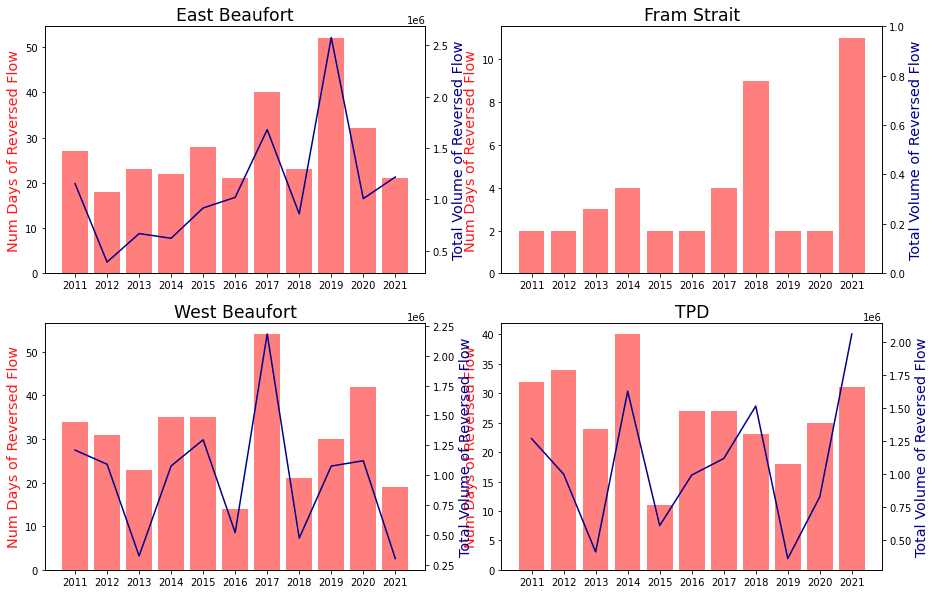

In [54]:
rev_gate = 'TPD'

fig, axs = plt.subplots(2,2,figsize=(15,10))

sum_revs_dict = {}
days_rev_dict = {}

for rev_gate, ax in zip(gate_names,axs.reshape(-1)):

    sum_revs = []
    days_rev = []

    for year in range(2011,2022):

        sum_revs.append(-np.nancumsum(rev_flow[rev_gate][year]))

        days_rev.append(np.count_nonzero(np.nan_to_num(rev_flow[rev_gate][year])))

    ax2 = ax.twinx()
    ax.set_xticks(range(2011,2022))
    ax.set_title(rev_gate, fontsize='xx-large')
    ax.bar(range(2011,2022), days_rev,color='r',alpha=0.5)
    
    if rev_gate != 'Fram Strait':
        ax2.plot(range(2011,2022), [i[-1] for i in sum_revs],color='darkblue')

    ax.set_ylabel('Num Days of Reversed Flow',color='r',alpha=0.9, fontsize='x-large')
    ax2.set_ylabel('Total Volume of Reversed Flow',color='darkblue', fontsize='x-large')
    
    sum_revs_dict[rev_gate] = [i[-1] for i in sum_revs]
    days_rev_dict[rev_gate] = days_rev

plt.show()

In [34]:
for key in rev_flow.keys():
    print(key,len(rev_flow[key]),np.nansum(rev_flow[key]))

2011 2 -28848.013369473152
2012 2 -11889.929853677762
2013 3 -12075.511551369475
2014 4 -21703.843216575402
2015 2 -31671.350320165104
2016 2 -23125.2199967497
2017 4 -14999.727363858497
2018 9 -44073.27593463771
2019 2 -5385.905760352713
2020 2 -6042.928097219844
2021 11 -33074.68666034048


In [95]:
gate_names

['East Beaufort', 'Fram Strait', 'West Beaufort', 'TPD']

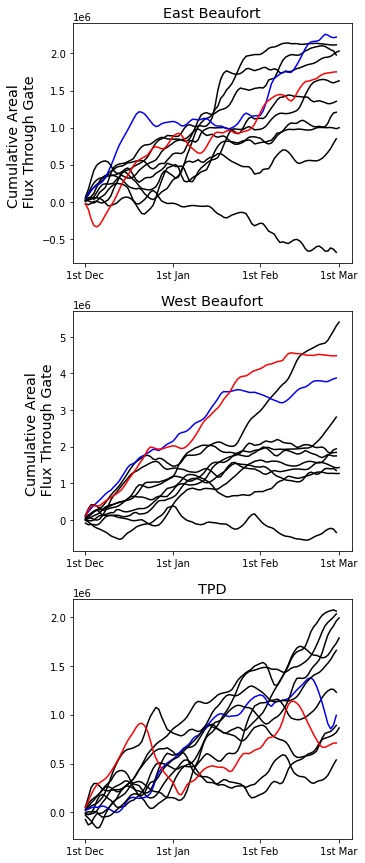

In [96]:
fig, axs = plt.subplots(3,1,figsize=(5,15))
for gate, ax in zip(['East Beaufort', 'West Beaufort', 'TPD'],axs.reshape(-1)):
    
    for year in range(2011,2022):

        dec = a_fluxes[gate][12][year-1]
        jan = a_fluxes[gate][1][year]
        feb = a_fluxes[gate][2][year]
        
#         print(jan)
        
        season = list(dec) + list(jan) + list(feb)

        if year == 2018:
            color = 'b'
        elif year < 2021:
            color='k'
        else:
            color='r'
            
        ax.plot(range(len(season)),np.nancumsum(season),color)
        

        
    ax.set_title(gate,fontsize='x-large')
    
    if gate in ['East Beaufort','West Beaufort']:
        
        ax.set_ylabel('Cumulative Areal \n Flux Through Gate', fontsize='x-large')
    
    ax.set_xticks([0,31,31+31,31+31+28])
    ax.set_xticklabels(['1st Dec', '1st Jan', '1st Feb', '1st Mar'])

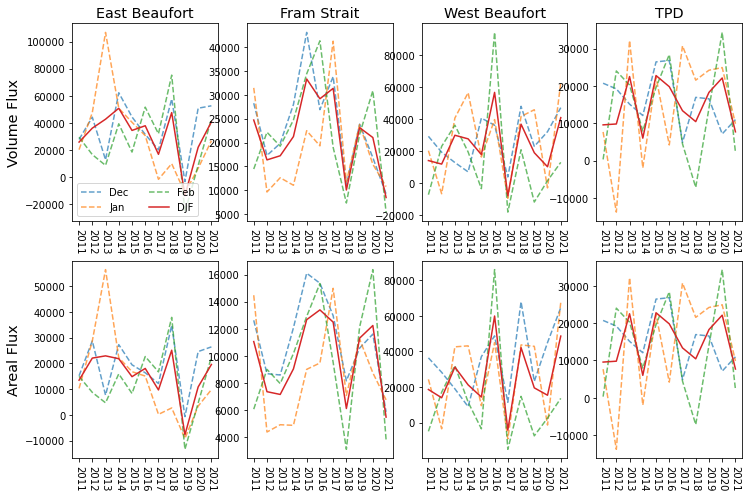

In [145]:
months_d = {1:'Jan',2:'Feb',12:'Dec'}

fig, axs = plt.subplots(2,4,figsize=(12,8))

for counter, (gate, ax) in enumerate(zip(2*gate_names,
                                         axs.reshape(-1))):
    
    d = v_fluxes if counter <3 else a_fluxes
    
    means_list = {}
    
    for month in [12,1,2]:
        
        # Plot the month's values for each year
        
#         counts = [np.count_nonzero(i) for i in v_fluxes[gate][month]] 
        
        means = [np.nanmean(d[gate][month][key]) for key in d[gate][month].keys()]
        
        means_list[month] = means
        
#         print(gate,month,means)
        
        ax.plot(years,means, ls='--',label=months_d[month],alpha=0.7)
    
    x = np.full((3,len(years)),np.nan)
    for c, key in enumerate(means_list):
        x[c] = means_list[key]
        
    
    ax.plot(years, np.nanmean(x,axis=0),label='DJF')    

    ax.set_xticks(years)
    ax.tick_params('x',rotation=270)

    if counter == 0: ax.set_ylabel('Volume Flux', fontsize='x-large')
    if counter == 4: ax.set_ylabel('Areal Flux', fontsize='x-large')

    if counter ==0: ax.legend(ncol=2,loc='lower left')
    
    if counter < 4:ax.set_title(gate, fontsize='x-large')
    
plt.show()

# Now calculate weekly area_fluxes with nsidc vectors

/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  


<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    version: QuickLook data based on Ice Motion version 4.1
    release_date: March 2021
    Conventions: CF-1.4
    citation: Tschudi, M. A., Meier, W. N., and Stewart, J. S.: An enhancement to sea ice motion and age products, The Cryosphere Discuss., https://doi.org/10.5194/tc-2019-40, in review, 2019.
    dataset_doi: 10.5067/O0XI8PPYEZJ6
    dimensions(sizes): x(361), y(361), time(61)
    variables(dimensions): float64 x(x), float64 y(y), float64 time(time), int32 crs(), float32 u(time,y,x), float32 v(time,y,x), int16 number_of_observations(time,y,x), float32 latitude(y,x), float32 longitude(y,x)
    groups: 



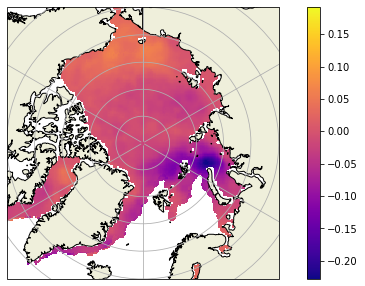

In [13]:
d = Dataset('/media/robbie/TOSHIBA EXT/weekly_NSIDC_IMV/icemotion_weekly_nh_25km_20200101_20210304_ql.nc')

u = d['u'][48:61]
v = d['v'][48:61]

print(d)

u = np.ma.masked_where(u == -9999, u)
v = np.ma.masked_where(v == -9999, v)
u = np.ma.filled(u,np.nan)/100
v = np.ma.filled(v,np.nan)/100

# for i in range(12):
cartoplot(d['longitude'],d['latitude'],u[-1])

In [14]:

    
#     break

    

100%|██████████| 42/42 [00:05<00:00,  7.97it/s]


In [15]:
pickle.dump(vels, open('vels.p','wb'))

In [12]:
def calculate_area_flux(gate_velocities, concs, gate_data, line):

    rel_points = [(x,y) for (x,y,p) in zip(
                                        x_grid.ravel(),
                                        y_grid.ravel(),
                                        gate_data.ravel(),
                                       ) if p==1]

    area_arr = np.full(gate_velocities.shape[0], np.nan)

    for i in range(area_arr.shape[0]):
        
        val_vels = [v for (v,p) in zip(gate_velocities[i].ravel(),gate_data.ravel()) if ~np.isnan(p)]
        
        dist = [line.project(Point(rel_points[i])) for i in range(len(val_vels))]

        af, bin_edges, bn = binned_statistic(dist,val_vels,bins=20)
        
        plt.plot(bin_edges[1:],af)
        
        area_arr[i] = np.trapz(np.nan_to_num(af),bin_edges[1:])

    return (area_arr)


  0%|          | 0/42 [00:00<?, ?it/s]

East Beaufort


  0%|          | 0/42 [00:00<?, ?it/s]

Fram Strait


  0%|          | 0/42 [00:00<?, ?it/s]

West Beaufort


  0%|          | 0/42 [00:00<?, ?it/s]

TPD


100%|██████████| 42/42 [04:19<00:00,  6.19s/it]


In [16]:
# pickle.dump(a_fluxes_wkly, open('figure2/wklyfluxes.p','wb'))

a_fluxes_wkly = pickle.load(open('figure2/wklyfluxes.p','rb'))

a_fluxes_wkly.keys()

dict_keys(['East Beaufort', 'Fram Strait', 'West Beaufort', 'TPD'])

100%|██████████| 42/42 [00:00<00:00, 541.61it/s]


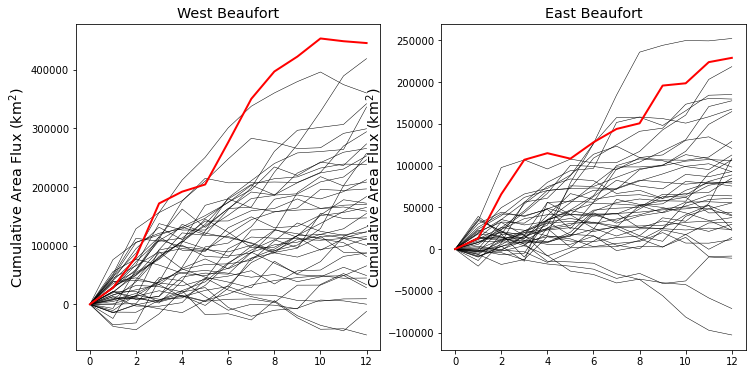

In [19]:
years = tqdm.trange(1980,2022)

# for gate in gate_names:
    
fig, axs = plt.subplots(1,2,figsize=(12,6))
    

for gate, ax in zip(['West Beaufort', 'East Beaufort'],axs.reshape(-1)):

    for year in years:
        if year != 2021:
            color='k'
            lw=0.5
        elif year == 2021:
            color = 'r'
            lw=2

#         if year == 2018: color = 'b'

        ax.plot(np.arange(13),[0]+list(np.cumsum(a_fluxes_wkly[gate][year])), color=color, lw=lw)

    ax.set_ylabel(r'Cumulative Area Flux (km$^2$)', fontsize='x-large')
    ax.set_title(gate,fontsize='x-large')
plt.show()

100%|██████████| 42/42 [00:00<00:00, 552.64it/s]


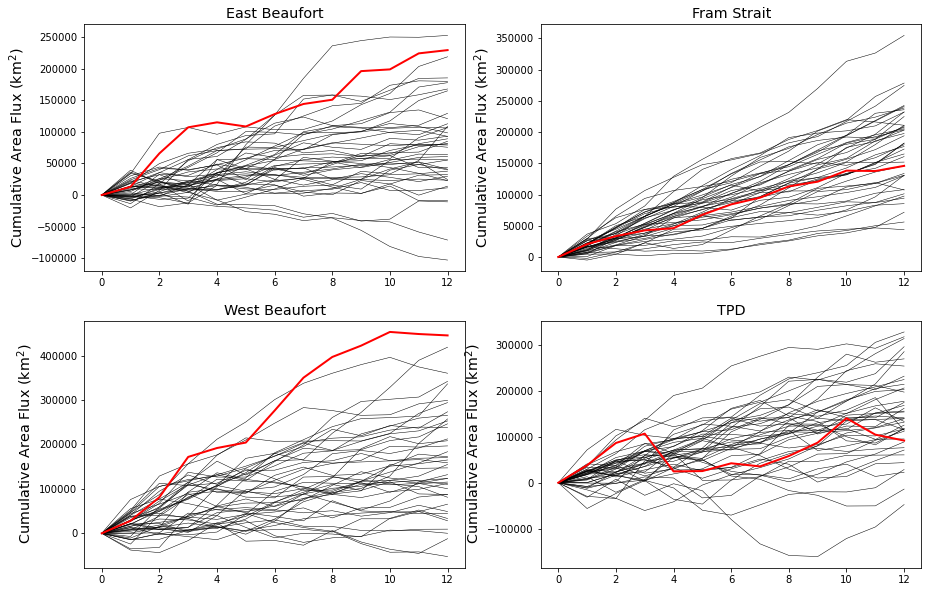

In [18]:

# for gate in gate_names:
    
fig, axs = plt.subplots(2,2,figsize=(15,10))
    

for gate, ax in zip(gate_names,axs.reshape(-1)):

    for year in years:
        
#         if 2010 < year <= 2020:
#             color='lightblue'
#         elif 2000 < year <= 2010:
#             color='plum'
#         elif 1990 < year <= 2000:
#             color='gold'
#         elif 1980 <= year <= 1990:
#             color='greenyellow'
        if year != 2021:
            color='k'
            lw=0.5
        elif year == 2021:
            color = 'r'
            lw=2

#         if year == 2018: color = 'b'

        ax.plot(np.arange(13),[0]+list(np.cumsum(a_fluxes_wkly[gate][year])), color=color, lw=lw)

    ax.set_ylabel(r'Cumulative Area Flux (km$^2$)', fontsize='x-large')
    ax.set_title(gate,fontsize='x-large')
plt.show()

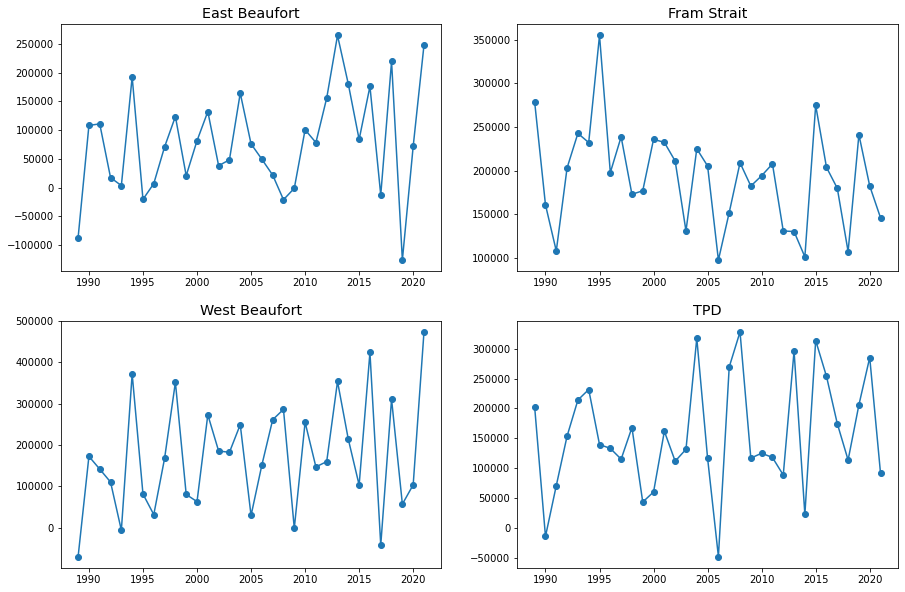

In [21]:
from scipy.stats import pearsonr

In [22]:
pearsonr(flux_series['West Beaufort'], flux_series['East Beaufort'])

(0.7075341053918518, 1.6126904567987414e-07)

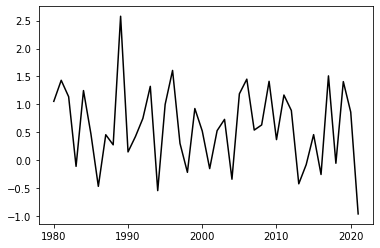

Text(0.05, 0.12, 'WB Corr = -0.86')

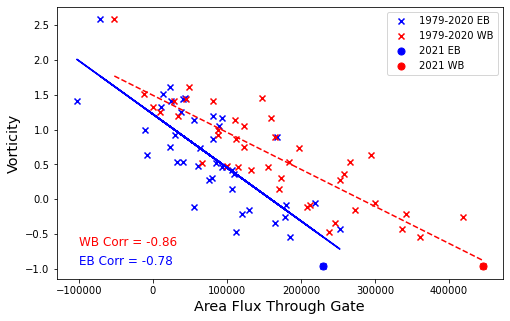

In [28]:
corr_d = (flux_series,ann_means)
pickle.dump(corr_d, open('figure2_v2/corr_d.p','wb'))

fig, ax = plt.subplots(1,1,figsize=(8,5))

ax.scatter(flux_series['East Beaufort'], ann_means,color='b', marker='x', label='1979-2020 EB')
ax.scatter(flux_series['West Beaufort'], ann_means,color='r', marker='x', label='1979-2020 WB')

ax.scatter(flux_series['East Beaufort'][-1], ann_means[-1],color='b', marker='o',s=50, label='2021 EB')
ax.scatter(flux_series['West Beaufort'][-1], ann_means[-1],color='r', marker='o',s=50, label='2021 WB')

z = np.polyfit(flux_series['East Beaufort'], ann_means, 1)
p = np.poly1d(z)
plt.plot(flux_series['East Beaufort'], p(flux_series['East Beaufort']),color='b')

z = np.polyfit(flux_series['West Beaufort'], ann_means, 1)
p = np.poly1d(z)
ax.plot( [min(flux_series['West Beaufort']),max(flux_series['West Beaufort'])],
       p([min(flux_series['West Beaufort']),max(flux_series['West Beaufort'])]),color='r',marker='None',ls='--')

ax.set_xlabel('Area Flux Through Gate', fontsize='x-large')

ax.set_ylabel('Vorticity', fontsize='x-large')

plt.legend()

ebcorr = np.round(pearsonr(flux_series['East Beaufort'], ann_means)[0], decimals=2)
wbcorr = np.round(pearsonr(flux_series['West Beaufort'], ann_means)[0], decimals=2)

ax.annotate(text=f'EB Corr = {ebcorr}',xy=(0.05,0.05),xycoords='axes fraction', fontsize='large', color='b')
ax.annotate(text=f'WB Corr = {wbcorr}',xy=(0.05,0.12),xycoords='axes fraction', fontsize='large', color='r')

Text(0.05, 0.12, 'WB Corr = -0.84')

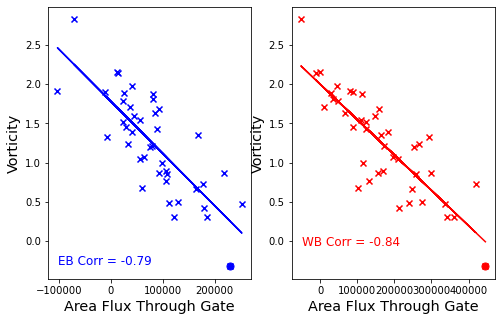

In [41]:
days_rev_dict

{'Fram Strait': [32, 34, 24, 40, 11, 27, 27, 23, 18, 25, 31]}

In [55]:
sum_revs_dict['East Beaufort']

[1151861.801883466,
 388092.87909882126,
 665327.710640716,
 619821.199110593,
 914930.4815209622,
 1018373.4242807496,
 1678247.0397792095,
 857483.994394067,
 2576222.313004252,
 1006019.2716590492,
 1217152.7149401838]

Text(0.05, 0.12, 'WB Corr = -0.84')

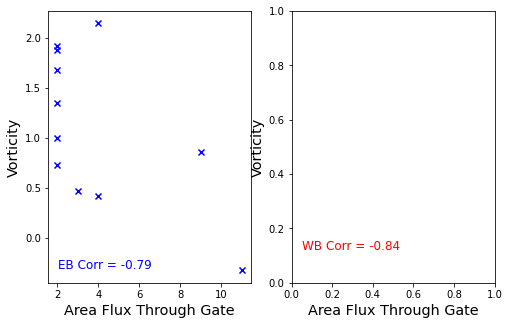

In [135]:
corr_d = (flux_series,ann_means)
pickle.dump(corr_d, open('figure2_v2/corr_d.p','wb'))

fig, (axl, axr) = plt.subplots(1,2,figsize=(8,5))

axl.scatter(days_rev_dict['Fram Strait'], ann_means[-11:],color='b', marker='x', label='1979-2020 EB')
# axr.scatter(flux_series['West Beaufort'], ann_means,color='r', marker='x', label='1979-2020 WB')

# axl.scatter(flux_series['East Beaufort'][-1], ann_means[-1],color='b', marker='o',s=50, label='2021 EB')
# axr.scatter(flux_series['West Beaufort'][-1], ann_means[-1],color='r', marker='o',s=50, label='2021 WB')

# z = np.polyfit(flux_series['East Beaufort'], ann_means, 1)
# p = np.poly1d(z)
# axl.plot(flux_series['East Beaufort'], p(flux_series['East Beaufort']),color='b')

# z = np.polyfit(flux_series['West Beaufort'], ann_means, 1)
# p = np.poly1d(z)
# axr.plot(flux_series['West Beaufort'], p(flux_series['West Beaufort']),color='r',marker='None')

for ax in [axl,axr]:
    ax.set_xlabel('Area Flux Through Gate', fontsize='x-large')
    ax.set_ylabel('Vorticity', fontsize='x-large')

ebcorr = np.round(pearsonr(flux_series['East Beaufort'], ann_means)[0], decimals=2)
wbcorr = np.round(pearsonr(flux_series['West Beaufort'], ann_means)[0], decimals=2)

axl.annotate(text=f'EB Corr = {ebcorr}',xy=(0.05,0.05),xycoords='axes fraction', fontsize='large', color='b')
axr.annotate(text=f'WB Corr = {wbcorr}',xy=(0.05,0.12),xycoords='axes fraction', fontsize='large', color='r')

In [74]:
years = np.arange(2011,2022)

a_fluxes = {}

for gate in gate_names:

    a_fluxes[gate] = {12:[],
                       1:[],
                       2:[]}
    
    for month in [12,1,2]:

        for year in years:    

            if month > 5:
                year = year-1

        #     d = Dataset(f'/home/robbie/Dropbox/Data/IMV/icemotion_daily_nh_25km_{year}0101_{year}1231_v4.1.nc')
            d = Dataset(f'/media/robbie/TOSHIBA EXT/weekly_NSIDC_IMV/icemotion_weekly_nh_25km_{year}0101_{year}1231_v4.1.nc')

            start_doy, end_doy = get_month_start_end_doy(month,year)

            swoy, ewoy = int(start_doy/7), int(end_doy/7)

            if year == 2021: 
                swoy += 52
                ewoy += 52
                
                print(swoy,ewoy)

            sow_u = np.nanmean(d['u'][swoy:ewoy+1],axis=0)
            sow_v = np.nanmean(d['v'][swoy:ewoy+1],axis=0)

            angle_r = gate_dict[gate]['angle_r']
            
            if gate == 'East Beaufort':
                gate_comp = sow_v * np.sin(angle_r)  - sow_u * np.cos(angle_r)
            elif gate == 'West Beaufort':
                gate_comp = sow_v * np.sin(angle_r)  - sow_u * np.cos(angle_r)
            elif gate == 'Fram Strait':
                gate_comp = sow_u * np.cos(angle_r) - sow_v * np.sin(angle_r)
            else:
                print(gate)
                raise
            
            gate_data = gate_dict[gate]['gate']

            gate_velocities = np.multiply(gate_comp, gate_data)

            SIT = get_awi_cs2(month,year)

            SIT_flux = np.multiply(SIT, gate_velocities)

        #     cartoplot(lon_grid, lat_grid, SIT_flux)

            vol_flux = np.nanmean(SIT_flux)
            area_flux = np.nanmean(gate_velocities)

            a_fluxes[gate][month].append(area_flux)

months_d = {1:'Jan',2:'Feb',12:'Dec'}

fig, axs = plt.subplots(2,3,figsize=(12,8))

for counter, (gate, ax) in enumerate(zip(2*gate_names,
                                         axs.reshape(-1))):
    
    print(counter)
    
    d = v_fluxes if counter <3 else a_fluxes
    
    for month in [12,1,2]:
        ax.plot(years,d[gate][month], ls='--',label=months_d[month],alpha=0.7)

    ax.plot(years, np.nanmean([d[gate][1],
                                d[gate][2],
                                d[gate][12]],axis=0),label='DJF')    

    ax.set_xticks(years)
    ax.tick_params('x',rotation=270)

    if counter == 0: ax.set_ylabel('Volume Flux', fontsize='x-large')
    if counter == 3: ax.set_ylabel('Areal Flux', fontsize='x-large')

    if counter ==0: ax.legend(ncol=2,loc='lower left')
    
    if counter < 3:ax.set_title(gate, fontsize='x-large')
    
plt.show()

NameError: name 'get_awi_cs2' is not defined

Text(0, 0.5, 'Ice Volume Flux')

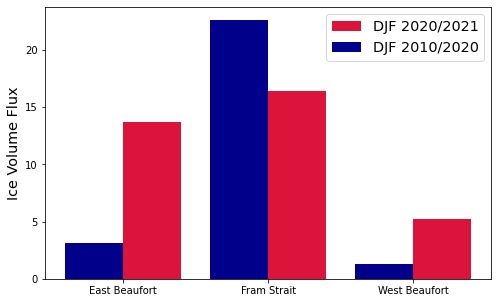

In [17]:
d = v_fluxes

djf_clim_vals = []
djf_2021_vals = []

for gate in gate_names:
    
    djf_clim = []
    djf_2021 = []
    
    for month in [12,1,2]:
    
        djf_clim.append(np.nanmean(d[gate][month][:-1]))
        djf_2021.append(np.nanmean(d[gate][month][-1]))
        
    djf_clim_vals.append(np.nanmean(djf_clim))
    djf_2021_vals.append(np.nanmean(djf_2021))


ind = np.arange(len(gate_names))


fig, ax = plt.subplots(1,1,figsize=(8,5))

ax.bar(ind+0.2,djf_2021_vals, width=0.4, color='crimson', label='DJF 2020/2021')
ax.bar(ind-0.2,djf_clim_vals, width=0.4, color='darkblue', label= 'DJF 2010/2020')
ax.set_xticks([0,1,2])
ax.set_xticklabels(gate_names)
ax.legend(fontsize='x-large')
ax.set_ylabel('Ice Volume Flux', fontsize='x-large')

In [3]:
from netCDF4 import Dataset

d = Dataset('/media/robbie/TOSHIBA EXT/weekly_NSIDC_IMV/icemotion_weekly_nh_25km_20210101_20211231_v4.1.nc')

d

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    version: QuickLook data based on Ice Motion version 4.1
    release_date: February 2021
    Conventions: CF-1.4
    citation: Tschudi, M. A., Meier, W. N., and Stewart, J. S.: An enhancement to sea ice motion and age products, The Cryosphere Discuss., https://doi.org/10.5194/tc-2019-40, in review, 2019.
    dataset_doi: 10.5067/O0XI8PPYEZJ6
    dimensions(sizes): x(361), y(361), time(57)
    variables(dimensions): float64 x(x), float64 y(y), float64 time(time), int32 crs(), float32 u(time,y,x), float32 v(time,y,x), int16 number_of_observations(time,y,x), float32 latitude(y,x), float32 longitude(y,x)
    groups: 

In [8]:
d = Dataset('/home/robbie/Dropbox/SM_Thickness/data/AWI_CS2/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-201211-fv2p3.nc')
awi_lons = np.array(d['lon'])
awi_lats = np.array(d['lat'])

awi_x, awi_y = lonlat_to_xy(awi_lons,awi_lats,hemisphere='n')

points = np.column_stack((awi_x.ravel(),awi_y.ravel()))

tri = Delaunay(points)  # Compute the triangulation

ease_x, ease_y = lonlat_to_xy(lon_grid,lat_grid,hemisphere='n')

In [126]:
from scipy.interpolate import LinearNDInterpolator
import pickle
from astropy.convolution import Gaussian2DKernel
from scipy.signal import convolve as scipy_convolve
from astropy.convolution import convolve

In [106]:
awi_raw_dir = '/home/robbie/Dropbox/SM_Thickness/data/AWI_CS2'
awi_files = os.listdir(awi_raw_dir)

for file in tqdm.tqdm(awi_files):
    
    if 'rep' in file:
        
        with Dataset(f'{awi_raw_dir}/{file}') as d:
            
            SIT = np.array(d['sea_ice_thickness'])
            interpolator = LinearNDInterpolator(tri, SIT.ravel())
            ease_SIT = interpolator((ease_x,ease_y))
            
        pickle.dump(ease_SIT, open(tosh_drive+file[:-2]+'p', 'wb'))

In [115]:
Dataset('/home/robbie/Dropbox/SM_Thickness/data/AWI_CS2/awi-siral-l3c-sithick-cryosat2-nrt-nh_25km_ease2-20210208_20210214-fv2p3.nc')

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: Monthly gridded sea-ice thickness and auxiliary parameters from satellite radar altimeter data
    institution: Alfred-Wegener-Institut Helmholtz Zentrum für Polar und Meeresforschung (AWI)
    source: Altimetry: CryoSat-2 Level 1b baseline D (ipf1-d), Snow depth: Monthly climatology based on regional merging of Warren Climatology with 50% reduction for first-year sea ice in the central Arctic and AMSR-2 based snow depth from IUP Bremen in remaining ice-covered regions, Mean Sea Surface: DTU18 global mean sea surface, Sea ice Concentration: OSI-SAF (OSI-401-b), Sea ice type: OSI-SAF (OSI-403-c), Region code: Adapted from NSIDC region mask
    platform: SIRAL
    sensor: SIRAL
    history: 20210216T030857Z - Product generated with pysiral version 0.9.4.1
    references: Hendricks, S. and Ricker, R. (2019): Product User Guide & Algorithm Specification: AWI CryoSat-2 Sea Ice Thickness (version

/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


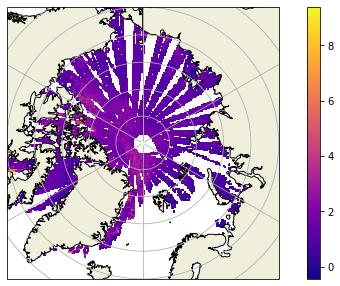

In [125]:
awi1 = np.array(Dataset('/home/robbie/Dropbox/SM_Thickness/data/AWI_CS2/awi-siral-l3c-sithick-cryosat2-nrt-nh_25km_ease2-20210201_20210207-fv2p3.nc')['sea_ice_thickness'])[0]
awi2 = np.array(Dataset('/home/robbie/Dropbox/SM_Thickness/data/AWI_CS2/awi-siral-l3c-sithick-cryosat2-nrt-nh_25km_ease2-20210208_20210214-fv2p3.nc')['sea_ice_thickness'])[0]

mean = np.nanmean(np.stack((awi1, awi2)),axis=0)

cartoplot(awi_lons, awi_lats, mean)

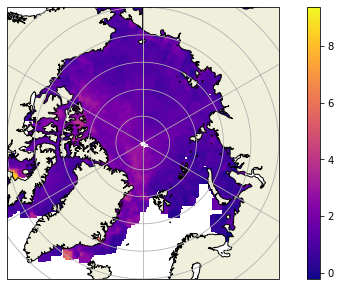

In [130]:
kernel = Gaussian2DKernel(x_stddev=1)
astro_conv = convolve(mean, kernel)
cartoplot(awi_lons, awi_lats, astro_conv)

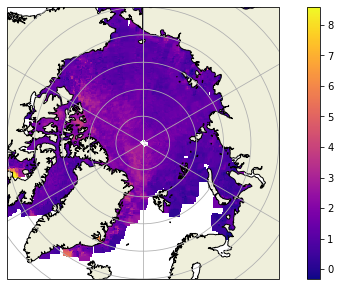

In [147]:
conv_nans = np.ma.masked_where(~np.isnan(mean), astro_conv)
conv_nans = np.ma.filled(conv_nans, np.nan)

filled_mean = np.add(np.nan_to_num(conv_nans), np.nan_to_num(mean))

filled_mean = np.ma.masked_where(filled_mean == 0, filled_mean)
filled_mean = np.ma.filled(filled_mean, np.nan)

interpolator = LinearNDInterpolator(tri, filled_mean.ravel())
filled_mean = interpolator((ease_x,ease_y))

pickle.dump(filled_mean, open(f'{tosh_drive}feb21.p','wb'))

cartoplot(lon_grid, lat_grid, filled_mean)

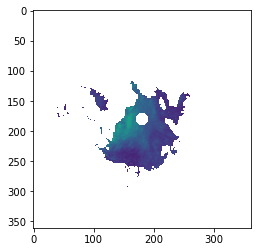

In [155]:

plt.imshow(get_awi_cs2(1,2020))
    